## Reconocimiento de Animales

In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras import backend
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import load_model
import itertools

In [25]:
print(tf.__version__)

2.10.1


In [26]:
#Setup data inputs
image_size= (128,128)
BATCH_SIZE = 64

In [27]:
tf.test.is_gpu_available()

True

In [28]:
path = 'D:/datasets/ANIMALES RED/'

In [29]:
data = {"imgpath": [] , "labels": [] }

In [30]:
category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      

df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

In [31]:
## Dataset
df.sample(n=10, random_state=1)

,imgpath,labels,encoded_labels
4739,D:/datasets/ANIMALES RED/mucca\OIP-GdxI-WFmFt9...,mucca,2
5605,D:/datasets/ANIMALES RED/mucca\OIP-vKiBGH0ARNI...,mucca,2
5495,D:/datasets/ANIMALES RED/mucca\OIP-TiiKQwMuSMj...,mucca,2
4205,D:/datasets/ANIMALES RED/mucca\OIP-5HZ3RpK3kS_...,mucca,2
3228,D:/datasets/ANIMALES RED/gatto\468.jpeg,gatto,1
2745,D:/datasets/ANIMALES RED/gatto\1552.jpeg,gatto,1
3611,D:/datasets/ANIMALES RED/gatto\ea30b0062af21c2...,gatto,1
3491,D:/datasets/ANIMALES RED/gatto\896.jpeg,gatto,1
1185,D:/datasets/ANIMALES RED/cane\OIP-skAoh56HSQvD...,cane,0
74,D:/datasets/ANIMALES RED/cane\OIP-LgbZBRDDbmMm...,cane,0


In [32]:
print("Shape of the dataset: ", df.shape)
print("_______________________________________")
print("Number of null values: ")
print(df.isnull().sum())
print("_______________________________________")
print("Number of unique values: ")
print(df.nunique())

print("---------------------------------------")
print("Number of images per category : ")
print(df.labels.value_counts()) 

Shape of the dataset:  (7997, 3)
_______________________________________
Number of null values: 
imgpath           0
labels            0
encoded_labels    0
dtype: int64
_______________________________________
Number of unique values: 
imgpath           7997
labels               4
encoded_labels       4
dtype: int64
---------------------------------------
Number of images per category : 
labels
cane     2347
ragno    2116
mucca    1866
gatto    1668
Name: count, dtype: int64


### Test y Entrenamiento

In [33]:
train_df, Temp_df = train_test_split(df,  train_size= 0.80 , shuffle=True, random_state=23)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.75 , shuffle=True, random_state=23)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [34]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath labels
0  D:/datasets/ANIMALES RED/ragno\OIP-r2C-MsShyT8...  ragno
1  D:/datasets/ANIMALES RED/mucca\OIP-CA4CXmzLyuH...  mucca
2  D:/datasets/ANIMALES RED/cane\OIP-U4uI7R0SWKKB...   cane
3  D:/datasets/ANIMALES RED/mucca\OIP-LczqZjufUmk...  mucca
4  D:/datasets/ANIMALES RED/ragno\OIP-Ogt5Yd8Ouit...  ragno
(6397, 3)
--------Validation----------
                                             imgpath labels
0  D:/datasets/ANIMALES RED/ragno\OIP-pGihxbFt0b1...  ragno
1  D:/datasets/ANIMALES RED/mucca\OIP-lEqCbGfRJ17...  mucca
2            D:/datasets/ANIMALES RED/gatto\942.jpeg  gatto
3  D:/datasets/ANIMALES RED/mucca\OIP-88viiIkkE5y...  mucca
4  D:/datasets/ANIMALES RED/cane\OIP-POHuPgRqMu0A...   cane
(1200, 3)
----------Test--------------
                                             imgpath labels
0  D:/datasets/ANIMALES RED/cane\OIP-ue-Dlsitayfp...   cane
1  D:/datasets/ANIMALES RED/ragno\OIP-Vo7oj39_hrp... 

Text(0.5, 1.0, 'Distribución de Clases')

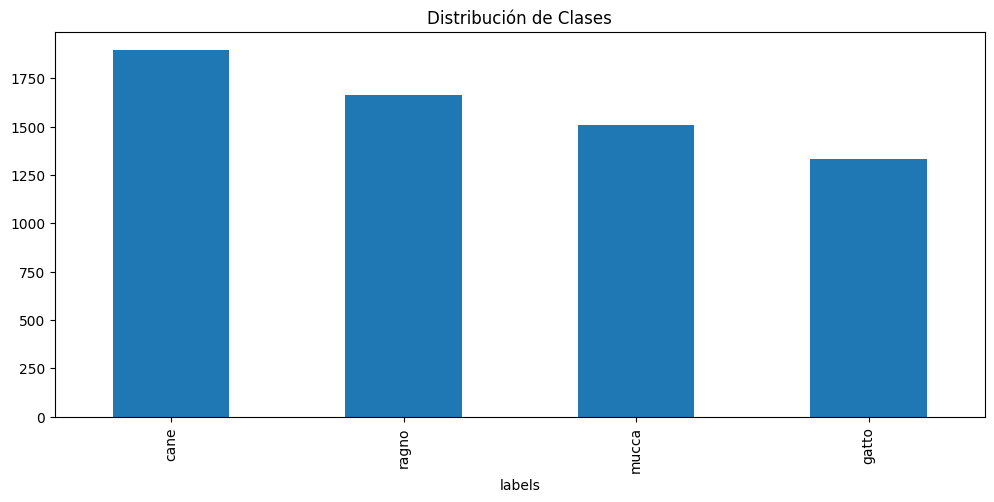

In [35]:
# Visualización de las distribuciones de clases en el conjunto de entrenamiento y prueba
plt.figure(figsize=(12, 5))
train_df['labels'].value_counts().transpose().plot(kind='bar')
plt.title('Distribución de Clases')

Text(0.5, 1.0, 'Distribución de Clases - Conjunto de Test')

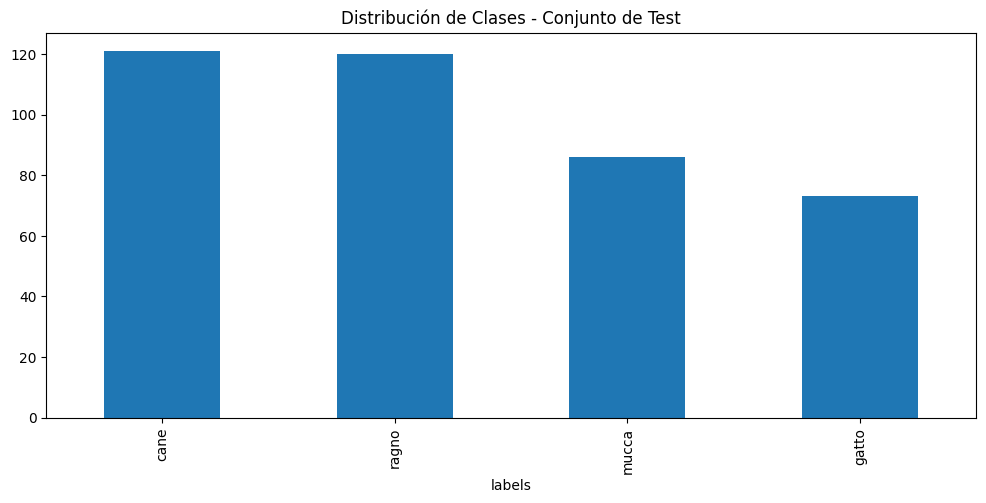

In [36]:
# Visualización de las distribuciones de clases en el conjunto de entrenamiento y prueba
plt.figure(figsize=(12, 5))
test_df['labels'].value_counts().transpose().plot(kind='bar')
plt.title('Distribución de Clases - Conjunto de Test')

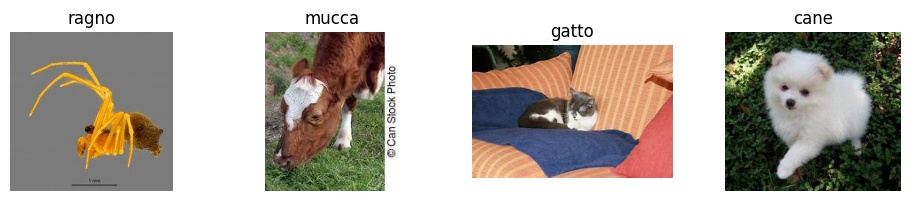

In [37]:
plt.figure(figsize=(15,12))
for i, label in enumerate(valid_df['labels'].unique()):
    # Selecciona una fila aleatoria con la etiqueta actual
    row = df[df['labels'] == label].sample(n=1).iloc[0]
    
    # Carga la imagen y la muestra
    image_path = row['imgpath']
    image = Image.open(image_path)
    
    # Configura la subfigura actual
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

### Creating Dataloaders

In [38]:
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)

generador = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

training_set = generador.flow_from_dataframe(dataframe=train_df,
                                                x_col='imgpath',
                                                y_col='labels',
                                                batch_size=BATCH_SIZE,
                                                target_size=IMAGE_SIZE,
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

validation_set = generador.flow_from_dataframe(dataframe=valid_df,
                                                x_col='imgpath',
                                                y_col='labels',
                                                batch_size=BATCH_SIZE,
                                                target_size=IMAGE_SIZE,
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')


test_set = generador.flow_from_dataframe(dataframe=test_df,
                                                x_col='imgpath',
                                                y_col='labels',
                                                batch_size=BATCH_SIZE,
                                                target_size=IMAGE_SIZE,
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 6397 validated image filenames belonging to 4 classes.
Found 1200 validated image filenames belonging to 4 classes.
Found 400 validated image filenames belonging to 4 classes.


In [39]:
training_set.class_indices

{'cane': 0, 'gatto': 1, 'mucca': 2, 'ragno': 3}

### Arquitectura


In [40]:
weight_decay = 1e-4

num_classes = 4

model = tf.keras.models.Sequential()

model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(128, 128, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="linear"))
model.add(Activation('elu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      1088      
                                                                 
 activation_6 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      65600     
                                                                 
 activation_7 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                      

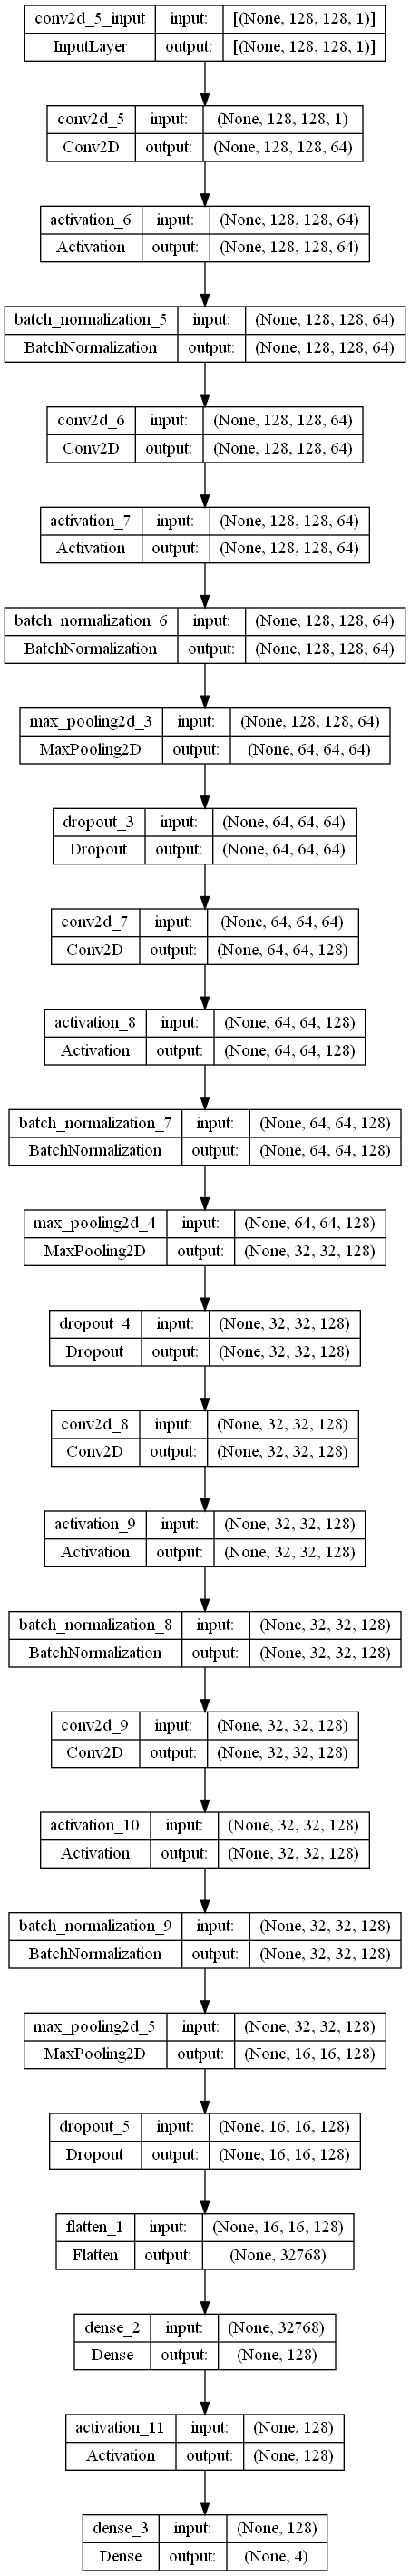

In [42]:
plot_model(model, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)

In [43]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 6),
                ModelCheckpoint(
                    filepath='model.weights.best.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

In [44]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

In [45]:
history = model.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=75,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/75
199/199 [==============================] - ETA: 0s - loss: 2.5818 - accuracy: 0.4093
Epoch 1: val_accuracy improved from -inf to 0.30659, saving model to model.weights.best.hdf5
199/199 [==============================] - 168s 830ms/step - loss: 2.5818 - accuracy: 0.4093 - val_loss: 1.6007 - val_accuracy: 0.3066
Epoch 2/75
199/199 [==============================] - ETA: 0s - loss: 1.1616 - accuracy: 0.5065
Epoch 2: val_accuracy improved from 0.30659 to 0.34544, saving model to model.weights.best.hdf5
199/199 [==============================] - 65s 323ms/step - loss: 1.1616 - accuracy: 0.5065 - val_loss: 1.7006 - val_accuracy: 0.3454
Epoch 3/75
199/199 [==============================] - ETA: 0s - loss: 1.0367 - accuracy: 0.5731
Epoch 3: val_accuracy improved from 0.34544 to 0.47466, saving model to model.weights.best.hdf5
199/199 [==============================] - 81s 405ms/step - loss: 1.0367 - accuracy: 0.5731 - val_loss: 1.3073 - val_accuracy: 0.4747
Epoch 4/75
199/199 [====

Text(0, 0.5, 'Loss')

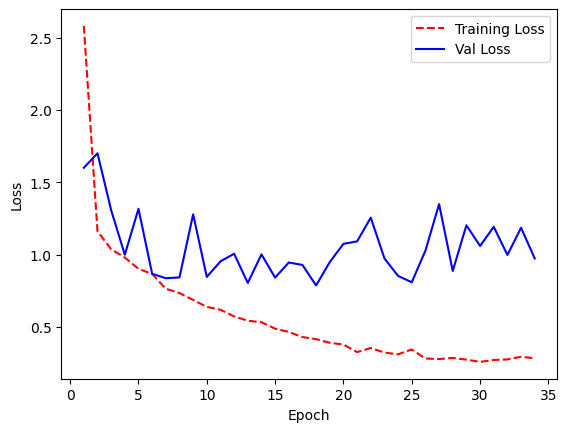

In [46]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

(0.2742581650614738, 1.0)

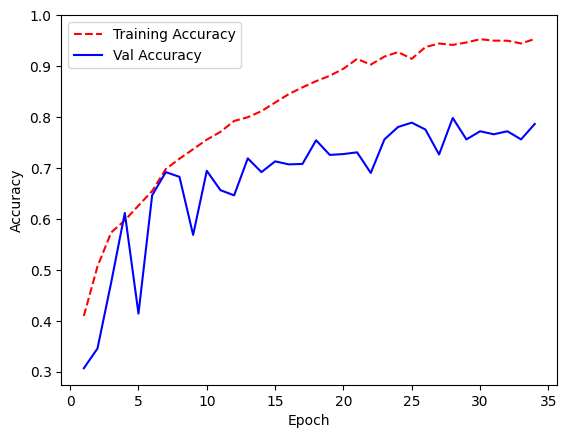

In [47]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)

In [48]:
model.save("cnn_model.h5")

In [49]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

12/12 [==============================] - 9s 769ms/step - loss: 0.8505 - accuracy: 0.7839
Test accuracy = 78.38541865348816%


### Matriz de Confusion

200/200 [==============================] - 27s 133ms/step
Confusion Matrix
[[569 410 460 457]
 [432 279 282 338]
 [505 296 346 359]
 [526 346 388 404]]
Classification Report
              precision    recall  f1-score   support

        cane       0.28      0.30      0.29      1896
       gatto       0.21      0.21      0.21      1331
       mucca       0.23      0.23      0.23      1506
       ragno       0.26      0.24      0.25      1664

    accuracy                           0.25      6397
   macro avg       0.25      0.25      0.25      6397
weighted avg       0.25      0.25      0.25      6397



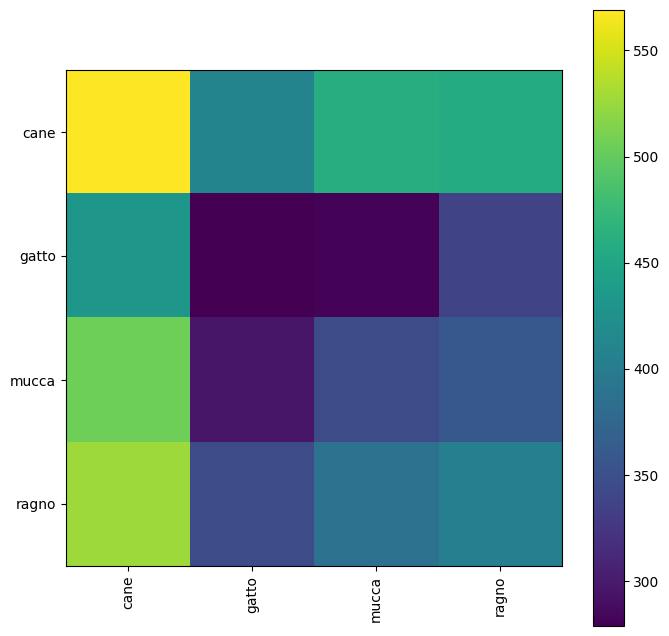

In [50]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

200/200 [==============================] - 20s 101ms/step


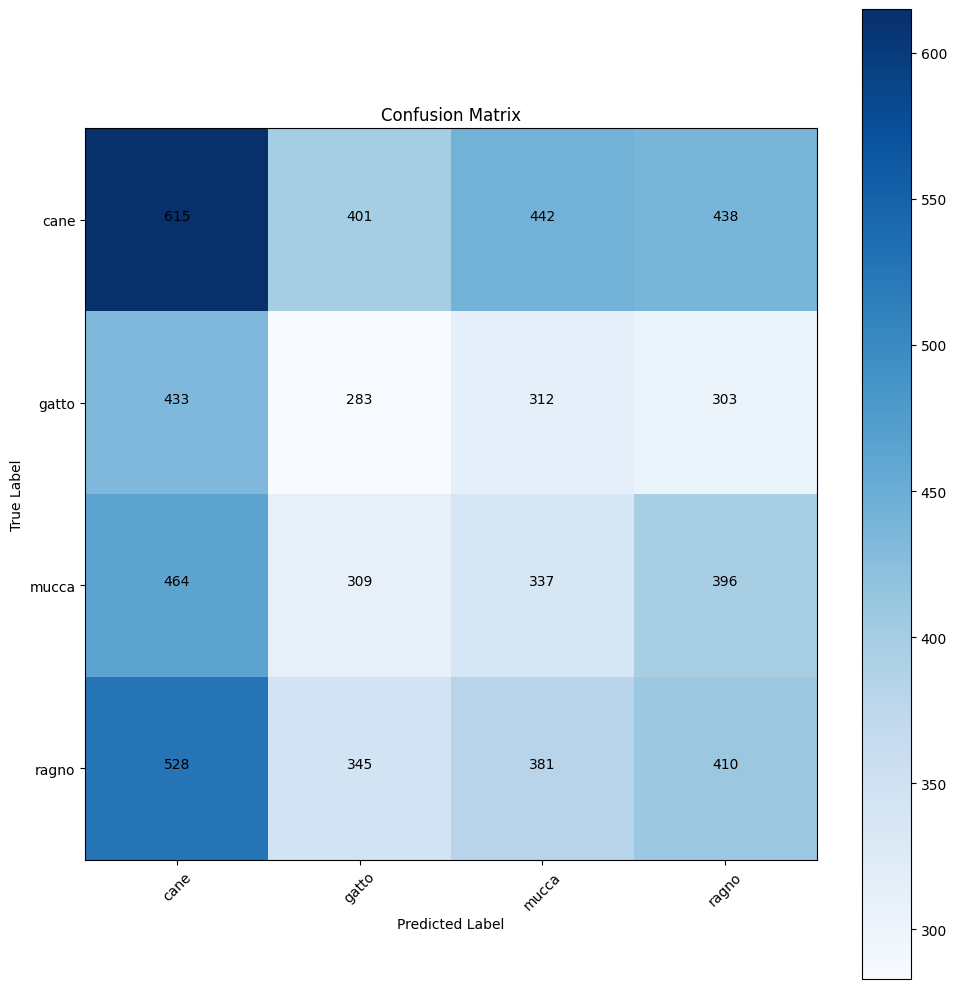

In [66]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)

g_dict = training_set.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(training_set.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()



38/38 [==============================] - 4s 93ms/step


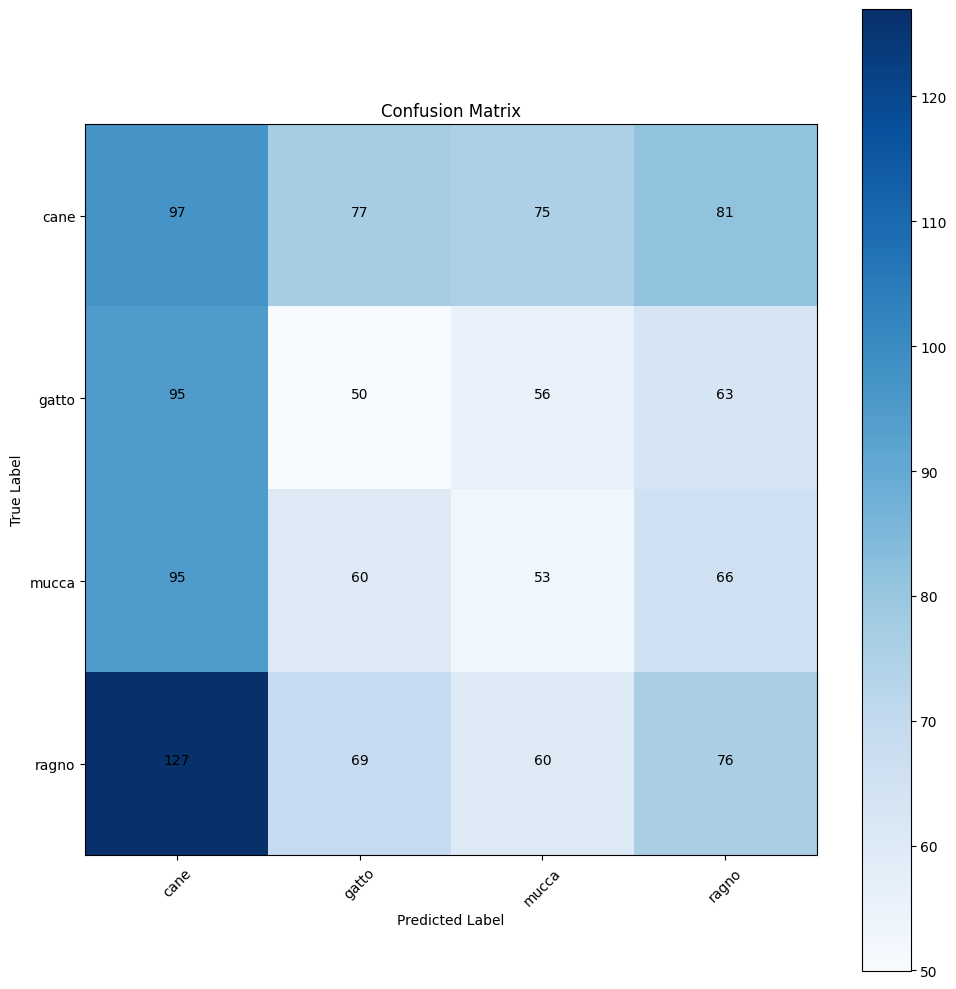

In [67]:
y_pred = model.predict(validation_set)
y_pred = np.argmax(y_pred, axis=1)

g_dict = validation_set.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(validation_set.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

13/13 [==============================] - 1s 100ms/step


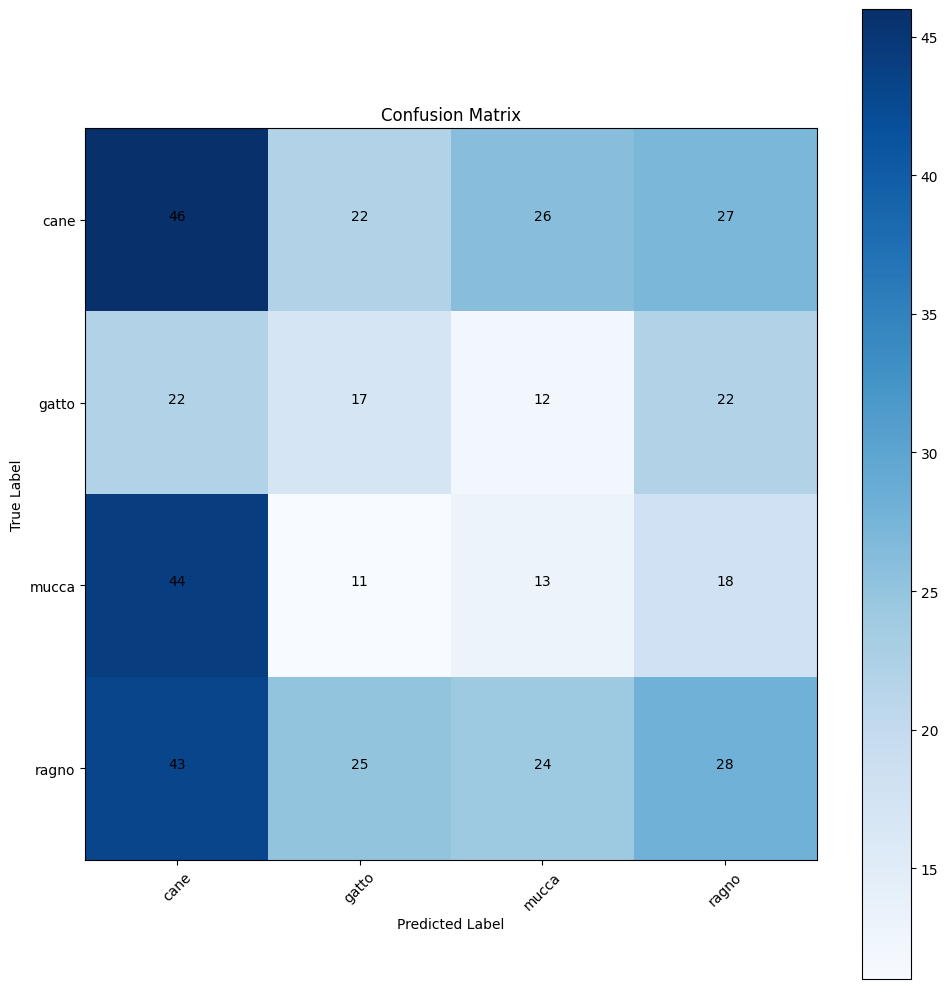

In [65]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

g_dict = test_set.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_set.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()



### Predicciones

In [57]:
# next function assigns one batch to variables, i.e x_test,y_test will have 64 images
x_test,y_test = next(test_set)
predict = model.predict(x_test)

1/1 [==============================] - 0s 223ms/step


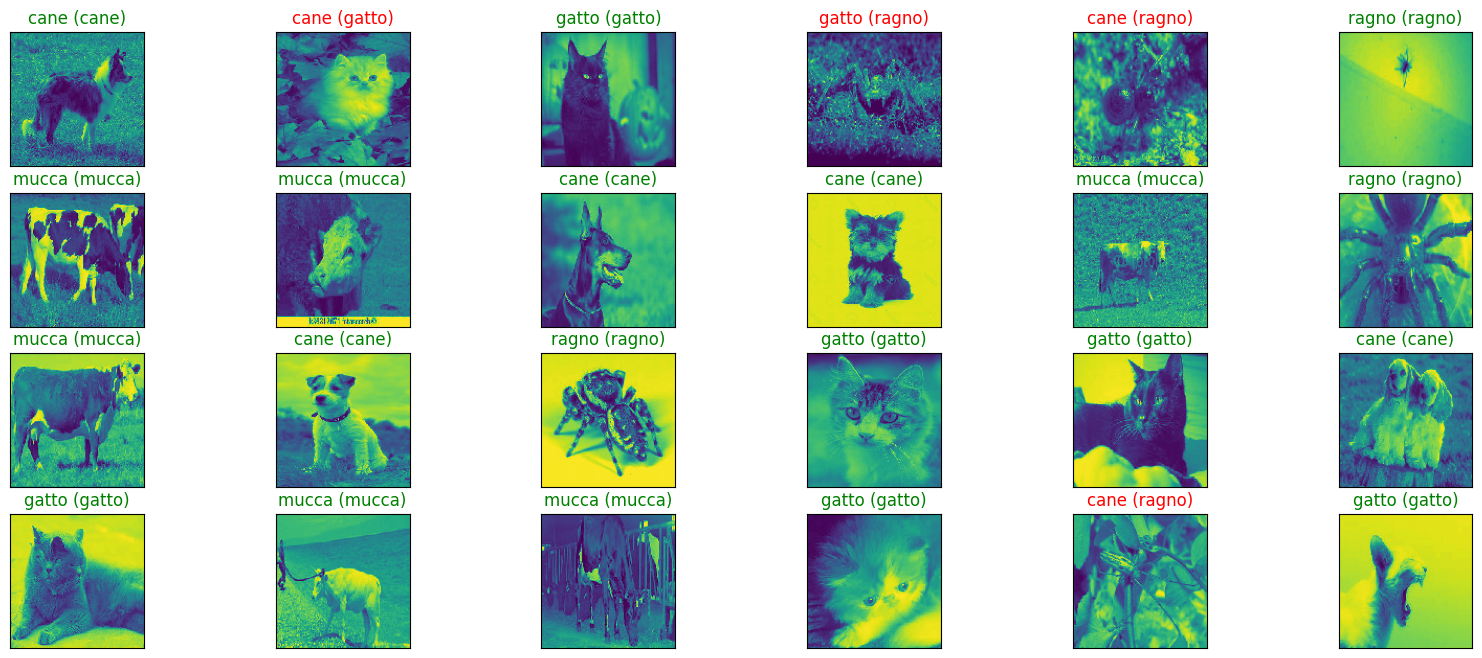

In [58]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))